In [1]:
using Revise
using GLMakie
using JLD2
using Gridap

In [2]:
function CoarsenSolution(uhPre, nCoarse, domain, elType) # for SingleFESolution
    partition = (nCoarse, nCoarse)
    TCoarse = CartesianDiscreteModel(domain,partition)
    reffeCoarse = ReferenceFE(lagrangian, elType, 2)
    VCoarse = FESpace(TCoarse, reffeCoarse)
    iuh = Gridap.CellData.Interpolable(uhPre)
    return interpolate_everywhere(iuh, VCoarse)
end


function CreateGrid(domain, nEvals)
    xDomain = LinRange(domain[1], domain[2], nEvals+1)
    yDomain = LinRange(domain[3], domain[4], nEvals+1)
    pts = [Gridap.Point(x,y) for x in xDomain, y in yDomain]
    return pts
end

function CreateGrid1D(domain, nEvals)
    xDomain = LinRange(domain[1], domain[2], nEvals+1)
    pts = [Gridap.Point(x) for x in xDomain]
    return pts
end

CreateGrid1D (generic function with 1 method)

In [100]:
### parameterization 

## mesh parameters
L = 500.0
n = 50
order = 1


## chemical parameters
kAct = 5e1  # mM^-1 s^-1 activation rate of calcium
kInact = 5e0  # s^-1 inactivation rate of calcium
kTrap = 3e2  # mM^-1 s^-1 trapping rate of calcium by DMNP
kRel = 7e2  # s^-1 release rate of calcium by DMNP when light is on
kIBind =  1e-1  # mM^-1 s^-1 binding rate of inactivated TCB2
kIUnbind = 1e0  # s^-1 unbinding rate of inactivated TCB2
kABind = 1e-1  # mM^-1 s^-1 binding rate of activated TCB2
kAUnbind = 0  # s^-1 unbinding rate of activated TCB2
β = 0.9  # degradation factor
CSat = 3  # mM, saturation concentration of bound TCB2

DT = 1  # μm^2/s, diffusion constant for TCB2
DD = 25  # μm^2/s, diffusion constant for DMNP
DC = 500  # μm^2/s, diffusion constant for calcium

CDI0 = 2.5  # mM
CDA0 = 0  # mM
CBI0 = 0.1  # mM
CBA0 = 0  # mM
CC0 = 0  # mM
CDst0 = 20  # mM
CD0 = 20 # mM

## light protocol parameters
protocol = "p"

if protocol == "p"
    lent = 1
    cyct = 30
else
    lent = 5
    cyct = 1000
end

width = 5  # μm, width of gaussian beam
r0 = 75  # μm, radius of circle
len = lent  # s
cyc = cyct + len
del = 0.25  # s

println("Loaded parameters.")

Loaded parameters.


In [101]:
### Define the necessary functions

function BS(CB, CSat)
    return CSat^2 / 4 - (CB - CSat / 2)^2
end

function gaussian(r, r0, s)
    return exp(-0.5 * ((r - r0) / s)^2)
end

function spaceFunc(r, r0, s)
    return 0.5 * (1 - tanh((r - r0) / s))
end

function rFunc(x, y, x0, y0)
    return sqrt((x - x0)^2 + (y - y0)^2)
end

function sigmoid(x)
    return 1 / (1 + exp(-x))
end

function smoothBump(x, a, xa, xb)
    return sigmoid((x - xa) / a) - sigmoid((x - xb) / a)
end

function waveFunc(t, cyc, len, del)
    s = 0.0
    for i in 0:floor(tMax / cyc)
        s += smoothBump(t, del, cyc * i, cyc * i + len)
    end
    return s
end

iFun(t) = waveFunc(t, cyc, len, del)

function gamFunc(px, t)
    return kRel * spaceFunc(rFunc(px[1], px[2], xMax / 2, yMax / 2), r0, width) * iFun(t)
end

function pA(CBA, CBI)
    return CBA / (CBA + CBI)
end

function g(CBA, CBI)
    return -(1 - gMin) * pA(CBA, CBI)
end

function RDI(CDI, CDA, CBI, CBA, CC, CD, CDst)
    return -kAct * CDI * CC + kInact * CDA - kIBind * CDI * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) + kIUnbind * CBI
end

function RDA(CDI, CDA, CBI, CBA, CC, CD, CDst)
    return kAct * CDI * CC - kInact * CDA - kABind * CDA * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) + kAUnbind * CBA
end

function RBI(CDI, CDA, CBI, CBA, CC, CD, CDst)
    return -kAct * CBI * CC + kInact * CBA + kIBind * CDI * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) - kIUnbind * CBI
end

function RBA(CDI, CDA, CBI, CBA, CC, CD, CDst)
    return kAct * CBI * CC - kInact * CBA + kABind * CDA * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) - kAUnbind * CBA
end

function RC(CDI, CDA, CBI, CBA, CC, CD, CDst)
    return -kAct * (CDI + CBI) * CC + kInact * (CDA + CBA) - kTrap * CDst * CC 
end

function RCGam(px, t, CDI, CDA, CBI, CBA, CC, CD, CDst)
    return  gamFunc(px, t) * CD
end

function RD(CDI, CDA, CBI, CBA, CC, CD, CDst)
    return kTrap * CDst * CC 
end

function RDGam(px, t, CDI, CDA, CBI, CBA, CC, CD, CDst)
    return - gamFunc(px, t) * CD
end

function RDst(CDI, CDA, CBI, CBA, CC, CD, CDst, β)
    return -kTrap * CDst * CC 
end

function RDstGam(px, t, CDI, CDA, CBI, CBA, CC, CD, CDst, β)
    return gamFunc(px, t) * CD * β
end

RDstGam (generic function with 1 method)

In [47]:
px = get_physical_coordinate(Ω)
# pxSub = px.cell
# gamFunc(px[1], px[2], 1)

GenericCellField():
 num_cells: 2500
 DomainStyle: PhysicalDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12726194806930849216

In [102]:
### Reaction-diffusion equation with Neumann boundary - multi field

## define domain size and discretization
domain = (0.0, L, 0.0, L)
partition = (n, n)

model = CartesianDiscreteModel(domain, partition)

## Domains
degree = 2*order
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)
px = get_physical_coordinate(Ω)

## FE paces
reffe = ReferenceFE(lagrangian, Float64, order)

VDI = TestFESpace(model, reffe, conformity = :H1)
VDA = TestFESpace(model, reffe, conformity = :H1)
VBI = TestFESpace(model, reffe, conformity = :H1)
VBA = TestFESpace(model, reffe, conformity = :H1)
VC = TestFESpace(model, reffe, conformity = :H1)
VD = TestFESpace(model, reffe, conformity = :H1)
VDst = TestFESpace(model, reffe, conformity = :H1)

UDI = TransientTrialFESpace(VDI)
UDA = TransientTrialFESpace(VDA)
UBI = TransientTrialFESpace(VBI)
UBA = TransientTrialFESpace(VBA)
UC= TransientTrialFESpace(VC)
UD = TransientTrialFESpace(VD)
UDst = TransientTrialFESpace(VDst)

Y = MultiFieldFESpace([VDI, VDA, VBI, VBA, VC, VD, VDst])
X = TransientMultiFieldFESpace([UDI, UDA, UBI, UBA, UC, UD, UDst])
    
## weak form
residual(t, (uDI, uDA, uBI, uBA, uC, uD, uDst), (vDI, vDA, vBI, vBA, vC, vD, vDst)) = ∫( 
    ( ∂t(uDI) * vDI + ∂t(uDA) * vDA + ∂t(uBI) * vBI + ∂t(uBA) * vBA + ∂t(uC) * vC + ∂t(uD) * vD + ∂t(uDst) * vDst ) + # time derivatives 
    ( DT * (∇(uDA)⋅∇(vDA)) + DT * (∇(uDI)⋅∇(vDI)) + DC * (∇(uC)⋅∇(vC)) + DD * (∇(uD)⋅∇(vD)) + DD * (∇(uDst)⋅∇(vDst)) ) # diffusion terms
    # ( RDI(uDI, uDA, uBI, uBA, uC, uD, uDst) * vDI + RDA(uDI, uDA, uBI, uBA, uC, uD, uDst) * vDA +    # reaction terms
    #   RBI(uDI, uDA, uBI, uBA, uC, uD, uDst) * vBI + RBA(uDI, uDA, uBI, uBA, uC, uD, uDst) * vBA +    # reaction terms
    #   RC(uDI, uDA, uBI, uBA, uC, uD, uDst) * vC +                                                    # reaction terms
    #   RD(uDI, uDA, uBI, uBA, uC, uD, uDst) * vD + RDst(uDI, uDA, uBI, uBA, uC, uD, uDst, β) * vDst ) # reaction terms
    )dΩ

op = TransientFEOperator(residual, X, Y)

## Initial conditions
cDIInit(x)  = CDI0
cDAInit(x)  = CDA0
cBIInit(x)  = CBI0
cBAInit(x)  = CBA0
cCInit(x)   = CC0
cDInit(x)   = CD0
cDstInit(x) = CDst0

u0 = interpolate_everywhere([cDIInit, cDAInit, cBIInit, cBAInit, cCInit, cDInit, cDstInit], X(0.0))


MultiFieldFEFunction():
 num_cells: 2500
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 5668163397569763281

In [110]:
### Reaction-diffusion equation with Neumann boundary - multi field reduced

function RDI(CDI, CDA, CBI, CBA)
    return -kAct * CDI * 1 + kInact * CDA - kIBind * CDI * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) + kIUnbind * CBI
end

function RDA(CDI, CDA, CBI, CBA)
    return kAct * CDI * 1 - kInact * CDA - kABind * CDA * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) + kAUnbind * CBA
end

function RBI(CDI, CDA, CBI, CBA)
    return -kAct * CBI * 1 + kInact * CBA + kIBind * CDI * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) - kIUnbind * CBI
end

function RBA(CDI, CDA, CBI, CBA)
    return kAct * CBI * 1 - kInact * CBA + kABind * CDA * (CSat^2 / 4 - (CBA + CBI - CSat / 2) * (CBA + CBI - CSat / 2)) - kAUnbind * CBA
end


## define domain size and discretization
domain = (0.0, L, 0.0, L)
partition = (n, n)

model = CartesianDiscreteModel(domain, partition)

## Domains
degree = 2*order
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)
px = get_physical_coordinate(Ω)

## FE paces
reffe = ReferenceFE(lagrangian, Float64, order)

VDI = TestFESpace(model, reffe, conformity = :H1)
VDA = TestFESpace(model, reffe, conformity = :H1)
VBI = TestFESpace(model, reffe, conformity = :H1)
VBA = TestFESpace(model, reffe, conformity = :H1)
VC = TestFESpace(model, reffe, conformity = :H1)
VD = TestFESpace(model, reffe, conformity = :H1)
VDst = TestFESpace(model, reffe, conformity = :H1)

UDI = TransientTrialFESpace(VDI)
UDA = TransientTrialFESpace(VDA)
UBI = TransientTrialFESpace(VBI)
UBA = TransientTrialFESpace(VBA)
UC= TransientTrialFESpace(VC)
UD = TransientTrialFESpace(VD)
UDst = TransientTrialFESpace(VDst)

Y = MultiFieldFESpace([VDI, VDA, VBI, VBA, VC, VD, VDst])
X = TransientMultiFieldFESpace([UDI, UDA, UBI, UBA, UC, UD, UDst])
    
## weak form
residual(t, (uDI, uDA, uBI, uBA), (vDI, vDA, vBI, vBA)) = ∫( 
    ( ∂t(uDI) * vDI + ∂t(uDA) * vDA + ∂t(uBI) * vBI + ∂t(uBA) * vBA ) + # time derivatives 
    ( DT * (∇(uDA)⋅∇(vDA)) + DT * (∇(uDI)⋅∇(vDI)) ) - # diffusion terms
    ( RDI(uDI, uDA, uBI, uBA) * vDI + RDA(uDI, uDA, uBI, uBA) * vDA +    # reaction terms
      RBI(uDI, uDA, uBI, uBA) * vBI + RBA(uDI, uDA, uBI, uBA) * vBA )    # reaction terms
    )dΩ

op = TransientFEOperator(residual, X, Y)

## Initial conditions
cDIInit(x)  = CDI0
cDAInit(x)  = CDA0
cBIInit(x)  = CBI0
cBAInit(x)  = CBA0
cCInit(x)   = CC0
cDInit(x)   = CD0
cDstInit(x) = CDst0

u0 = interpolate_everywhere([cDIInit, cDAInit, cBIInit, cBAInit], X(0.0))

MultiFieldFEFunction():
 num_cells: 2500
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 8290138047985508356

In [ ]:
dt = 0.1
tMax = 1.0

## Solver
solver = NLSolver(method = :newton)
θ = 0.5
ode_solver = ThetaMethod(solver, dt, θ)
uht = solve(ode_solver, op, u0, 0.0, tMax)

uhList = []
coarseGridList = []
@time for (uh, t) in uht    
    push!(uhList, deepcopy(uh))
    #@show t 
end
    

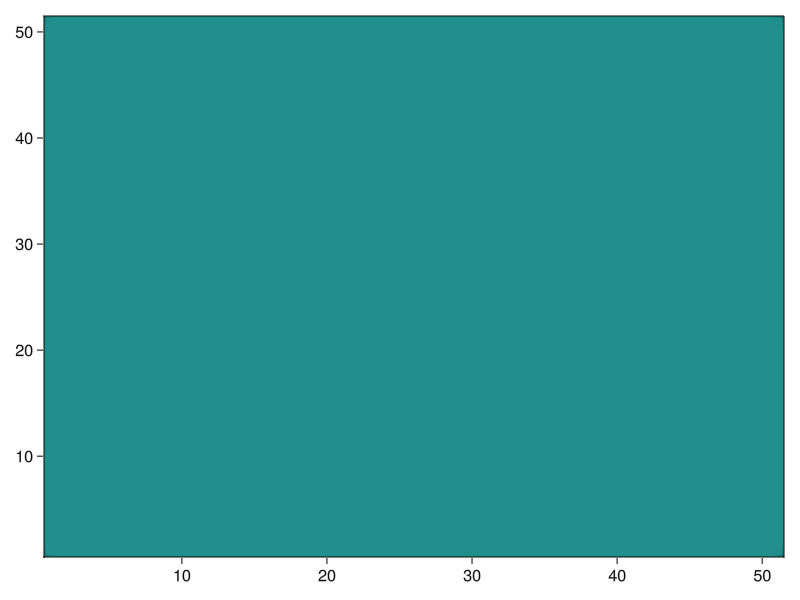

In [104]:
nCoarse = 50
coarseGrid = CreateGrid(domain, nCoarse)

Makie.heatmap(uhList[end].single_fe_functions[1].(coarseGrid))
#Makie.ylims!(0, 0.6)
current_figure()

In [93]:
Makie.lines([uhList[t].single_fe_functions[8].(coarseGrid)[25,25] for t in 1:length(uhList)])

LoadError: BoundsError: attempt to access 7-element Vector{Gridap.FESpaces.SingleFieldFEFunction{Gridap.CellData.GenericCellField{ReferenceDomain}}} at index [8]